Dataset source: https://finance.yahoo.com/quote/BMW.DE/history?period1=847411200&period2=1687219200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

Article source: https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks

# Importing libraries

In [149]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

# Data Preprocessing

In [150]:
ds = pd.read_csv('BMW.DE.csv')

In [151]:
ds.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-11-08,18.209999,18.209999,18.171000,18.171000,8.601855,767000.0
1,1996-11-11,18.190001,18.200001,18.082001,18.122000,8.578660,260000.0
2,1996-11-12,18.160999,18.327999,18.091999,18.259001,8.643515,1066000.0
3,1996-11-13,18.344000,18.344000,18.190001,18.230000,8.629785,793000.0
4,1996-11-14,18.205000,18.289000,18.132000,18.289000,8.657717,351000.0


In [152]:
print(ds.shape)

(6821, 7)


In [153]:
print(ds.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [154]:
print(ds['Date'])

0       1996-11-08
1       1996-11-11
2       1996-11-12
3       1996-11-13
4       1996-11-14
           ...    
6816    2023-06-13
6817    2023-06-14
6818    2023-06-15
6819    2023-06-16
6820    2023-06-19
Name: Date, Length: 6821, dtype: object


# Data Splitting

In [155]:
# Split Dataset 80/20 for train/test
train_test_split = int(len(ds) * 0.8)
columns = ['Close', 'Volume']
ds_train = ds.get(columns).values[:train_test_split]
ds_test = ds.get(columns).values[train_test_split:]
print(len(ds), len(ds_train), len(ds_test))

6821 5456 1365


5456 train samples

1365 test samples

In [156]:
ds_train.shape

(5456, 2)

In [157]:
ds_test.shape

(1365, 2)

# Model Training

In [158]:
# 50 elements = 49 + 1 (element to predict)
sequence_len = 50
input_dim = 2
batch_size = 32
epochs = 2

# Neural Network Composition:

First layer:
1. LSTM
2. 100 neurons
3. input_timesteps = 49
4. input_dim = 2
5. return_seq = True

Second Layer:
1. Dropout
2. rate = 0.2

Third Layer:
1. LSTM
2. 100 neurons
3. return_seq = True

Fourth Layer:
1. LSTM
2. 100 neurons
3. return_seq = False

Fifth Layer:
1. Dropout
2. rate = 0.2

Sixth Layer:
1. Dense
2. 1 neuron
3. activation = linear




In [159]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, input_shape=(sequence_len-1, input_dim), return_sequences=True),
    # Dropout to prevent overfitting and improve the generalization of the model
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

In [160]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 49, 100)           41200     
                                                                 
 dropout_15 (Dropout)        (None, 49, 100)           0         
                                                                 
 lstm_23 (LSTM)              (None, 49, 100)           80400     
                                                                 
 lstm_24 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_16 (Dropout)        (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 202,101
Trainable params: 202,101
Non-tr

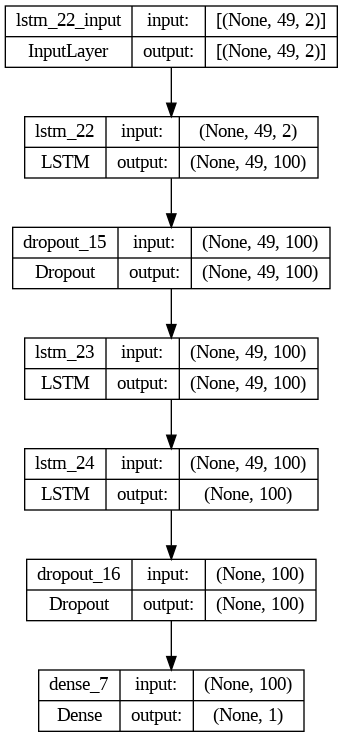

In [161]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [162]:
# Model Compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [163]:
model.compile(optimizer='adam',
              loss='mse')

In [164]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

In [165]:
def normalize_window(window_data, single_window=False):
  # Window normalization with a base value of zero
  normalized_data = []
  window_data = [window_data] if single_window else window_data
  for window in window_data:
    normalized_window = []
    for column_i in range(window.shape[1]):
      normalized_col = [((float(p) / float(window[0, column_i])) - 1) for p in window[:, column_i]]
      normalized_window.append(normalized_col)
    normalized_window = np.array(normalized_window)
    normalized_data.append(normalized_window)
  return np.array(normalized_data)

In [166]:
def next_window(i, sequence_len, normalize):
  window = ds_train[i:i+sequence_len]
  window = normalize_window(window, single_window=True)[0] if normalize else window
  x = window[:-1]
  y = window[-1, [0]]
  return x, y

In [167]:
def get_train_data(sequence_len, normalize):
  # Creates x, y train_data windows
  data_x = []
  data_y = []
  for i in range(len(ds_train) - sequence_len + 1):
    x, y = next_window(i, sequence_len, normalize)
    data_x.append(x)
    data_y.append(y)
  return np.array(data_x), np.array(data_y)

In [168]:
x, y = get_train_data(
    sequence_len=sequence_len,
    normalize=False
)

In [169]:
print(x)

[[[1.8171000e+01 7.6700000e+05]
  [1.8122000e+01 2.6000000e+05]
  [1.8259001e+01 1.0660000e+06]
  ...
  [2.1218000e+01 6.5000000e+05]
  [2.1927000e+01 1.0400000e+06]
  [2.1514000e+01 7.5400000e+05]]

 [[1.8122000e+01 2.6000000e+05]
  [1.8259001e+01 1.0660000e+06]
  [1.8230000e+01 7.9300000e+05]
  ...
  [2.1927000e+01 1.0400000e+06]
  [2.1514000e+01 7.5400000e+05]
  [2.1266001e+01 3.5100000e+05]]

 [[1.8259001e+01 1.0660000e+06]
  [1.8230000e+01 7.9300000e+05]
  [1.8289000e+01 3.5100000e+05]
  ...
  [2.1514000e+01 7.5400000e+05]
  [2.1266001e+01 3.5100000e+05]
  [2.1612000e+01 1.3130000e+06]]

 ...

 [[8.5330002e+01 1.1068800e+06]
  [8.4930000e+01 1.1845400e+06]
  [8.5180000e+01 1.3763550e+06]
  ...
  [9.4349998e+01 1.7495760e+06]
  [9.3250000e+01 2.7049830e+06]
  [9.3830002e+01 1.4760050e+06]]

 [[8.4930000e+01 1.1845400e+06]
  [8.5180000e+01 1.3763550e+06]
  [8.6779999e+01 2.2353390e+06]
  ...
  [9.3250000e+01 2.7049830e+06]
  [9.3830002e+01 1.4760050e+06]
  [9.3540001e+01 1.1657110e+

In [170]:
print(x.shape)

(5407, 49, 2)


In [171]:
print(y)

[[21.266001]
 [21.612   ]
 [21.396   ]
 ...
 [93.540001]
 [92.639999]
 [91.970001]]


In [172]:
print(y.shape)

(5407, 1)


In [173]:
steps_per_epoch = math.ceil((len(ds_train) - sequence_len) / batch_size)
print(steps_per_epoch)

169
